In [5]:
import numpy as np


class Node:
    # 该类为所有其他图节点类的父类
    def __init__(self, inputs=[]):
        #定义每个节点的输入和输出
        self.inputs = inputs
        self.outputs = []
        
        #每个节点都是其输入节点的输出节点
        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None
        
        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        #前向传播函数 继承该类的其他类会覆写该函数
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):
        #反向传播函数，继承该类的其他类会覆写该函数

        raise NotImplemented
        
class Input(Node):
    # 输入节点，包括神经网络输入节点，权重节点，和偏差节点
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        #定义节点数值
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        #计算节点梯度
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            #以下计算该节点的输出节点对该节点的梯度
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    #全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        #前向传播计算 y = w*x + b
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]
            #以下分别计算对inputs， weights, bias的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        #前向 即为sigmoid函数计算
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        #反向传播计算梯度
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        #反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [6]:
from sklearn.datasets import load_boston

In [7]:
data = load_boston()

In [8]:
losses = []

In [9]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 186.321
Epoch: 101, Loss: 8.133
Epoch: 201, Loss: 6.155
Epoch: 301, Loss: 5.278
Epoch: 401, Loss: 4.427
Epoch: 501, Loss: 3.777
Epoch: 601, Loss: 4.141
Epoch: 701, Loss: 4.031
Epoch: 801, Loss: 3.635
Epoch: 901, Loss: 4.391
Epoch: 1001, Loss: 3.616
Epoch: 1101, Loss: 3.505
Epoch: 1201, Loss: 3.434
Epoch: 1301, Loss: 3.563
Epoch: 1401, Loss: 3.614
Epoch: 1501, Loss: 3.632
Epoch: 1601, Loss: 3.431
Epoch: 1701, Loss: 4.079
Epoch: 1801, Loss: 3.571
Epoch: 1901, Loss: 3.752
Epoch: 2001, Loss: 3.551
Epoch: 2101, Loss: 3.436
Epoch: 2201, Loss: 3.380
Epoch: 2301, Loss: 3.725
Epoch: 2401, Loss: 3.905
Epoch: 2501, Loss: 3.813
Epoch: 2601, Loss: 3.759
Epoch: 2701, Loss: 3.331
Epoch: 2801, Loss: 3.245
Epoch: 2901, Loss: 3.302
Epoch: 3001, Loss: 2.928
Epoch: 3101, Loss: 3.504
Epoch: 3201, Loss: 3.180
Epoch: 3301, Loss: 3.613
Epoch: 3401, Loss: 3.074
Epoch: 3501, Loss: 3.662
Epoch: 3601, Loss: 3.532
Epoch: 3701, Loss: 3.554
Epoch: 3801, Loss: 3.058
Epoc

In [10]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [11]:
forward(l2,graph)

array([[33.96202069],
       [ 8.56132731],
       [20.62094846],
       [20.12677036],
       [35.47476168],
       [18.28982847],
       [28.87595139],
       [30.02259708],
       [20.26015169],
       [18.28982847],
       [49.53262354],
       [18.16420955],
       [21.53409713],
       [43.73451463],
       [ 8.24855926],
       [14.81980997]])

In [12]:
import matplotlib.pyplot as plt

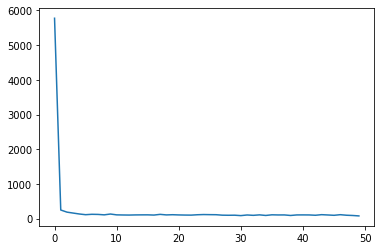

In [13]:
plt.plot(range(len(losses)), losses)

In [14]:
W2.value

array([[ 9.47382488],
       [10.14622887],
       [ 2.95264966],
       [14.48490353],
       [ 6.3321407 ],
       [-5.33577459],
       [ 7.90763291],
       [ 7.78930154],
       [13.4279327 ],
       [10.26423254]])

In [15]:
X_ = data['data']

In [16]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [17]:
import keras

In [18]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [19]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [20]:
model.fit(X_, y_, epochs=5000, batch_size=32)




Epoch 1/5000





506/506 [==============================] - 1s 1ms/step - loss: 140.7859 - mean_squared_error: 140.7859
Epoch 2/5000
506/506 [==============================] - 0s 32us/step - loss: 76.4942 - mean_squared_error: 76.4942
Epoch 3/5000
506/506 [==============================] - 0s 37us/step - loss: 80.6483 - mean_squared_error: 80.6483
Epoch 4/5000
506/506 [==============================] - 0s 45us/step - loss: 79.6805 - mean_squared_error: 79.6805
Epoch 5/5000
506/506 [==============================] - 0s 105us/step - loss: 81.2032 - mean_squared_error: 81.2032
Epoch 6/5000
506/506 [==============================] - 0s 30us/step - loss: 81.3648 - mean_squared_error: 81.3648
Epoch 7/5000
506/506 [==============================] - 0s 30us/step - loss: 82.2569 - mean_squared_error: 82.2569
Epoch 8/5000
506/506 [==============================] - 0s 30us/step - loss: 78.8453 - mean_squared_error: 78.8453
Epoch 9/5000
506/506 [==============================] - 0s 41us/step -

506/506 [==============================] - 0s 47us/step - loss: 77.7435 - mean_squared_error: 77.7435
Epoch 58/5000
506/506 [==============================] - 0s 45us/step - loss: 80.6238 - mean_squared_error: 80.6238
Epoch 59/5000
506/506 [==============================] - 0s 74us/step - loss: 78.7106 - mean_squared_error: 78.7106
Epoch 60/5000
506/506 [==============================] - 0s 28us/step - loss: 79.1544 - mean_squared_error: 79.1544
Epoch 61/5000
506/506 [==============================] - 0s 34us/step - loss: 78.0459 - mean_squared_error: 78.0459
Epoch 62/5000
506/506 [==============================] - 0s 35us/step - loss: 79.1420 - mean_squared_error: 79.1420
Epoch 63/5000
506/506 [==============================] - 0s 26us/step - loss: 78.7955 - mean_squared_error: 78.7955
Epoch 64/5000
506/506 [==============================] - 0s 41us/step - loss: 79.1396 - mean_squared_error: 79.1396
Epoch 65/5000
506/506 [==============================] - 0s 28us/step - loss: 78.2293 

506/506 [==============================] - 0s 26us/step - loss: 85.1501 - mean_squared_error: 85.1501
Epoch 128/5000
506/506 [==============================] - 0s 28us/step - loss: 84.1856 - mean_squared_error: 84.1856
Epoch 129/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7565 - mean_squared_error: 84.7565
Epoch 130/5000
506/506 [==============================] - 0s 47us/step - loss: 85.2024 - mean_squared_error: 85.2024
Epoch 131/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8175 - mean_squared_error: 84.8175
Epoch 132/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9983 - mean_squared_error: 84.9983
Epoch 133/5000
506/506 [==============================] - 0s 30us/step - loss: 84.9198 - mean_squared_error: 84.9198
Epoch 134/5000
506/506 [==============================] - 0s 28us/step - loss: 85.1338 - mean_squared_error: 85.1338
Epoch 135/5000
506/506 [==============================] - 0s 45us/step - loss: 

506/506 [==============================] - 0s 32us/step - loss: 84.5237 - mean_squared_error: 84.5237
Epoch 198/5000
506/506 [==============================] - 0s 26us/step - loss: 85.4386 - mean_squared_error: 85.4386
Epoch 199/5000
506/506 [==============================] - 0s 28us/step - loss: 85.3081 - mean_squared_error: 85.3081
Epoch 200/5000
506/506 [==============================] - 0s 26us/step - loss: 85.1253 - mean_squared_error: 85.1253
Epoch 201/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7312 - mean_squared_error: 84.7312
Epoch 202/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0514 - mean_squared_error: 85.0514
Epoch 203/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1840 - mean_squared_error: 85.1840
Epoch 204/5000
506/506 [==============================] - 0s 30us/step - loss: 85.1038 - mean_squared_error: 85.1038
Epoch 205/5000
506/506 [==============================] - 0s 28us/step - loss: 

506/506 [==============================] - 0s 24us/step - loss: 84.9678 - mean_squared_error: 84.9678
Epoch 268/5000
506/506 [==============================] - 0s 28us/step - loss: 85.3712 - mean_squared_error: 85.3712
Epoch 269/5000
506/506 [==============================] - 0s 26us/step - loss: 84.7720 - mean_squared_error: 84.7720
Epoch 270/5000
506/506 [==============================] - 0s 30us/step - loss: 85.1584 - mean_squared_error: 85.1584
Epoch 271/5000
506/506 [==============================] - 0s 26us/step - loss: 85.0601 - mean_squared_error: 85.0601
Epoch 272/5000
506/506 [==============================] - 0s 26us/step - loss: 85.1854 - mean_squared_error: 85.1854
Epoch 273/5000
506/506 [==============================] - 0s 32us/step - loss: 85.2656 - mean_squared_error: 85.2656
Epoch 274/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8690 - mean_squared_error: 84.8690
Epoch 275/5000
506/506 [==============================] - 0s 30us/step - loss: 

506/506 [==============================] - 0s 38us/step - loss: 77.1370 - mean_squared_error: 77.1370
Epoch 338/5000
506/506 [==============================] - 0s 51us/step - loss: 78.4008 - mean_squared_error: 78.4008
Epoch 339/5000
506/506 [==============================] - 0s 34us/step - loss: 78.1277 - mean_squared_error: 78.1277
Epoch 340/5000
506/506 [==============================] - 0s 35us/step - loss: 77.8365 - mean_squared_error: 77.8365
Epoch 341/5000
506/506 [==============================] - 0s 37us/step - loss: 77.2984 - mean_squared_error: 77.2984
Epoch 342/5000
506/506 [==============================] - 0s 39us/step - loss: 77.3332 - mean_squared_error: 77.3332
Epoch 343/5000
506/506 [==============================] - 0s 37us/step - loss: 79.0809 - mean_squared_error: 79.0809
Epoch 344/5000
506/506 [==============================] - 0s 41us/step - loss: 77.6020 - mean_squared_error: 77.6020
Epoch 345/5000
506/506 [==============================] - 0s 34us/step - loss: 

506/506 [==============================] - 0s 34us/step - loss: 77.3783 - mean_squared_error: 77.3783
Epoch 408/5000
506/506 [==============================] - 0s 34us/step - loss: 77.4127 - mean_squared_error: 77.4127
Epoch 409/5000
506/506 [==============================] - 0s 39us/step - loss: 77.4101 - mean_squared_error: 77.4101
Epoch 410/5000
506/506 [==============================] - 0s 30us/step - loss: 78.0445 - mean_squared_error: 78.0445
Epoch 411/5000
506/506 [==============================] - 0s 30us/step - loss: 77.0854 - mean_squared_error: 77.0854
Epoch 412/5000
506/506 [==============================] - 0s 32us/step - loss: 77.8531 - mean_squared_error: 77.8531
Epoch 413/5000
506/506 [==============================] - 0s 28us/step - loss: 77.7511 - mean_squared_error: 77.7511
Epoch 414/5000
506/506 [==============================] - 0s 30us/step - loss: 77.7380 - mean_squared_error: 77.7380
Epoch 415/5000
506/506 [==============================] - 0s 28us/step - loss: 

506/506 [==============================] - 0s 28us/step - loss: 77.3636 - mean_squared_error: 77.3636
Epoch 478/5000
506/506 [==============================] - 0s 31us/step - loss: 77.8366 - mean_squared_error: 77.8366
Epoch 479/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2214 - mean_squared_error: 77.2214
Epoch 480/5000
506/506 [==============================] - 0s 26us/step - loss: 77.8241 - mean_squared_error: 77.8241
Epoch 481/5000
506/506 [==============================] - 0s 30us/step - loss: 77.7489 - mean_squared_error: 77.7489
Epoch 482/5000
506/506 [==============================] - 0s 34us/step - loss: 77.4515 - mean_squared_error: 77.4515
Epoch 483/5000
506/506 [==============================] - 0s 39us/step - loss: 77.3077 - mean_squared_error: 77.3077
Epoch 484/5000
506/506 [==============================] - 0s 34us/step - loss: 77.0586 - mean_squared_error: 77.0586
Epoch 485/5000
506/506 [==============================] - 0s 32us/step - loss: 

506/506 [==============================] - 0s 30us/step - loss: 84.3122 - mean_squared_error: 84.3122
Epoch 548/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0253 - mean_squared_error: 85.0253
Epoch 549/5000
506/506 [==============================] - 0s 28us/step - loss: 85.0867 - mean_squared_error: 85.0867
Epoch 550/5000
506/506 [==============================] - 0s 30us/step - loss: 84.5367 - mean_squared_error: 84.5367
Epoch 551/5000
506/506 [==============================] - 0s 81us/step - loss: 84.5234 - mean_squared_error: 84.5234
Epoch 552/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8835 - mean_squared_error: 84.8835
Epoch 553/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7804 - mean_squared_error: 84.7804
Epoch 554/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8737 - mean_squared_error: 84.8737
Epoch 555/5000
506/506 [==============================] - 0s 30us/step - loss: 

506/506 [==============================] - 0s 30us/step - loss: 85.6595 - mean_squared_error: 85.6595
Epoch 618/5000
506/506 [==============================] - 0s 32us/step - loss: 84.6413 - mean_squared_error: 84.6413
Epoch 619/5000
506/506 [==============================] - 0s 28us/step - loss: 85.6752 - mean_squared_error: 85.6752
Epoch 620/5000
506/506 [==============================] - 0s 35us/step - loss: 85.1179 - mean_squared_error: 85.1179
Epoch 621/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0245 - mean_squared_error: 85.0245
Epoch 622/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8806 - mean_squared_error: 84.8806
Epoch 623/5000
506/506 [==============================] - 0s 26us/step - loss: 85.2322 - mean_squared_error: 85.2322
Epoch 624/5000
506/506 [==============================] - 0s 41us/step - loss: 84.5772 - mean_squared_error: 84.5772
Epoch 625/5000
506/506 [==============================] - 0s 37us/step - loss: 

506/506 [==============================] - 0s 30us/step - loss: 84.9254 - mean_squared_error: 84.9254
Epoch 688/5000
506/506 [==============================] - 0s 26us/step - loss: 85.3299 - mean_squared_error: 85.3299
Epoch 689/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7947 - mean_squared_error: 84.7947
Epoch 690/5000
506/506 [==============================] - 0s 32us/step - loss: 85.4775 - mean_squared_error: 85.4775
Epoch 691/5000
506/506 [==============================] - 0s 28us/step - loss: 84.6599 - mean_squared_error: 84.6599
Epoch 692/5000
506/506 [==============================] - 0s 32us/step - loss: 84.4892 - mean_squared_error: 84.4892
Epoch 693/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7586 - mean_squared_error: 84.7586
Epoch 694/5000
506/506 [==============================] - 0s 30us/step - loss: 84.1306 - mean_squared_error: 84.1306
Epoch 695/5000
506/506 [==============================] - 0s 32us/step - loss: 

506/506 [==============================] - 0s 32us/step - loss: 84.8237 - mean_squared_error: 84.8237
Epoch 758/5000
506/506 [==============================] - 0s 26us/step - loss: 85.0044 - mean_squared_error: 85.0044
Epoch 759/5000
506/506 [==============================] - 0s 51us/step - loss: 84.7866 - mean_squared_error: 84.7866
Epoch 760/5000
506/506 [==============================] - 0s 36us/step - loss: 85.0812 - mean_squared_error: 85.0812
Epoch 761/5000
506/506 [==============================] - 0s 30us/step - loss: 84.9828 - mean_squared_error: 84.9828
Epoch 762/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6794 - mean_squared_error: 84.6794
Epoch 763/5000
506/506 [==============================] - 0s 28us/step - loss: 85.1169 - mean_squared_error: 85.1169
Epoch 764/5000
506/506 [==============================] - 0s 28us/step - loss: 85.8882 - mean_squared_error: 85.8882
Epoch 765/5000
506/506 [==============================] - 0s 32us/step - loss: 

506/506 [==============================] - 0s 37us/step - loss: 85.2885 - mean_squared_error: 85.2885
Epoch 827/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9118 - mean_squared_error: 84.9118
Epoch 828/5000
506/506 [==============================] - 0s 33us/step - loss: 85.3151 - mean_squared_error: 85.3151
Epoch 829/5000
506/506 [==============================] - 0s 39us/step - loss: 84.7622 - mean_squared_error: 84.7622
Epoch 830/5000
506/506 [==============================] - 0s 47us/step - loss: 85.2602 - mean_squared_error: 85.2602
Epoch 831/5000
506/506 [==============================] - 0s 32us/step - loss: 84.6474 - mean_squared_error: 84.6474
Epoch 832/5000
506/506 [==============================] - 0s 35us/step - loss: 84.6183 - mean_squared_error: 84.6183
Epoch 833/5000
506/506 [==============================] - 0s 36us/step - loss: 84.7218 - mean_squared_error: 84.7218
Epoch 834/5000
506/506 [==============================] - 0s 41us/step - loss: 

506/506 [==============================] - 0s 37us/step - loss: 85.3393 - mean_squared_error: 85.3393
Epoch 897/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8620 - mean_squared_error: 84.8620
Epoch 898/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1090 - mean_squared_error: 85.1090
Epoch 899/5000
506/506 [==============================] - 0s 33us/step - loss: 84.9256 - mean_squared_error: 84.9256
Epoch 900/5000
506/506 [==============================] - 0s 36us/step - loss: 85.0578 - mean_squared_error: 85.0578
Epoch 901/5000
506/506 [==============================] - 0s 35us/step - loss: 85.0213 - mean_squared_error: 85.0213
Epoch 902/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7430 - mean_squared_error: 84.7430
Epoch 903/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0452 - mean_squared_error: 85.0452
Epoch 904/5000
506/506 [==============================] - 0s 39us/step - loss: 

506/506 [==============================] - 0s 41us/step - loss: 84.9652 - mean_squared_error: 84.9652
Epoch 966/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8821 - mean_squared_error: 84.8821
Epoch 967/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0246 - mean_squared_error: 85.0246
Epoch 968/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8815 - mean_squared_error: 84.8815
Epoch 969/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7709 - mean_squared_error: 84.7709
Epoch 970/5000
506/506 [==============================] - 0s 45us/step - loss: 84.5164 - mean_squared_error: 84.5164
Epoch 971/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9332 - mean_squared_error: 84.9332
Epoch 972/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0697 - mean_squared_error: 85.0697
Epoch 973/5000
506/506 [==============================] - 0s 49us/step - loss: 

506/506 [==============================] - 0s 34us/step - loss: 85.2742 - mean_squared_error: 85.2742
Epoch 1035/5000
506/506 [==============================] - 0s 45us/step - loss: 84.3154 - mean_squared_error: 84.3154
Epoch 1036/5000
506/506 [==============================] - 0s 45us/step - loss: 85.2240 - mean_squared_error: 85.2240
Epoch 1037/5000
506/506 [==============================] - 0s 53us/step - loss: 85.4243 - mean_squared_error: 85.4243
Epoch 1038/5000
506/506 [==============================] - 0s 39us/step - loss: 84.5577 - mean_squared_error: 84.5577
Epoch 1039/5000
506/506 [==============================] - 0s 43us/step - loss: 85.4656 - mean_squared_error: 85.4656
Epoch 1040/5000
506/506 [==============================] - 0s 47us/step - loss: 84.7921 - mean_squared_error: 84.7921
Epoch 1041/5000
506/506 [==============================] - 0s 71us/step - loss: 84.1590 - mean_squared_error: 84.1590
Epoch 1042/5000
506/506 [==============================] - 0s 45us/step 

506/506 [==============================] - 0s 30us/step - loss: 85.5654 - mean_squared_error: 85.5654
Epoch 1104/5000
506/506 [==============================] - 0s 30us/step - loss: 84.9507 - mean_squared_error: 84.9507
Epoch 1105/5000
506/506 [==============================] - ETA: 0s - loss: 63.0812 - mean_squared_error: 63.08 - 0s 26us/step - loss: 85.1548 - mean_squared_error: 85.1548
Epoch 1106/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0854 - mean_squared_error: 85.0854
Epoch 1107/5000
506/506 [==============================] - 0s 39us/step - loss: 85.1180 - mean_squared_error: 85.1180
Epoch 1108/5000
506/506 [==============================] - 0s 34us/step - loss: 84.5519 - mean_squared_error: 84.5519
Epoch 1109/5000
506/506 [==============================] - 0s 26us/step - loss: 84.7402 - mean_squared_error: 84.7402
Epoch 1110/5000
506/506 [==============================] - 0s 26us/step - loss: 84.9904 - mean_squared_error: 84.9904
Epoch 1111/5000
50

506/506 [==============================] - 0s 26us/step - loss: 84.8296 - mean_squared_error: 84.8296
Epoch 1173/5000
506/506 [==============================] - 0s 28us/step - loss: 84.4862 - mean_squared_error: 84.4862
Epoch 1174/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9417 - mean_squared_error: 84.9417
Epoch 1175/5000
506/506 [==============================] - 0s 89us/step - loss: 84.7270 - mean_squared_error: 84.7270
Epoch 1176/5000
506/506 [==============================] - 0s 32us/step - loss: 84.6656 - mean_squared_error: 84.6656
Epoch 1177/5000
506/506 [==============================] - 0s 34us/step - loss: 84.5934 - mean_squared_error: 84.5934
Epoch 1178/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0381 - mean_squared_error: 85.0381
Epoch 1179/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8676 - mean_squared_error: 84.8676
Epoch 1180/5000
506/506 [==============================] - 0s 28us/step 

506/506 [==============================] - 0s 32us/step - loss: 84.6233 - mean_squared_error: 84.6233
Epoch 1242/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0279 - mean_squared_error: 85.0279
Epoch 1243/5000
506/506 [==============================] - 0s 28us/step - loss: 84.8528 - mean_squared_error: 84.8528
Epoch 1244/5000
506/506 [==============================] - 0s 32us/step - loss: 85.2021 - mean_squared_error: 85.2021
Epoch 1245/5000
506/506 [==============================] - 0s 30us/step - loss: 85.3234 - mean_squared_error: 85.3234
Epoch 1246/5000
506/506 [==============================] - 0s 69us/step - loss: 84.8458 - mean_squared_error: 84.8458
Epoch 1247/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6596 - mean_squared_error: 84.6596
Epoch 1248/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8245 - mean_squared_error: 84.8245
Epoch 1249/5000
506/506 [==============================] - 0s 43us/step 

506/506 [==============================] - 0s 26us/step - loss: 85.0093 - mean_squared_error: 85.0093
Epoch 1311/5000
506/506 [==============================] - 0s 67us/step - loss: 84.9161 - mean_squared_error: 84.9161
Epoch 1312/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8478 - mean_squared_error: 84.8478
Epoch 1313/5000
506/506 [==============================] - 0s 32us/step - loss: 84.6339 - mean_squared_error: 84.6339
Epoch 1314/5000
506/506 [==============================] - 0s 30us/step - loss: 84.9431 - mean_squared_error: 84.9431
Epoch 1315/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8107 - mean_squared_error: 84.8107
Epoch 1316/5000
506/506 [==============================] - 0s 32us/step - loss: 84.5283 - mean_squared_error: 84.5283
Epoch 1317/5000
506/506 [==============================] - 0s 30us/step - loss: 85.4827 - mean_squared_error: 85.4827
Epoch 1318/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.8532 - mean_squared_error: 84.8532
Epoch 1380/5000
506/506 [==============================] - 0s 45us/step - loss: 84.9006 - mean_squared_error: 84.9006
Epoch 1381/5000
506/506 [==============================] - 0s 30us/step - loss: 85.2793 - mean_squared_error: 85.2793
Epoch 1382/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0140 - mean_squared_error: 85.0140
Epoch 1383/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7983 - mean_squared_error: 84.7983
Epoch 1384/5000
506/506 [==============================] - 0s 35us/step - loss: 84.6393 - mean_squared_error: 84.6393
Epoch 1385/5000
506/506 [==============================] - 0s 30us/step - loss: 84.6087 - mean_squared_error: 84.6087
Epoch 1386/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8143 - mean_squared_error: 84.8143
Epoch 1387/5000
506/506 [==============================] - 0s 28us/step 

506/506 [==============================] - 0s 32us/step - loss: 84.6896 - mean_squared_error: 84.6896
Epoch 1449/5000
506/506 [==============================] - 0s 47us/step - loss: 85.0351 - mean_squared_error: 85.0351
Epoch 1450/5000
506/506 [==============================] - 0s 36us/step - loss: 84.9508 - mean_squared_error: 84.9508
Epoch 1451/5000
506/506 [==============================] - 0s 47us/step - loss: 84.7887 - mean_squared_error: 84.7887
Epoch 1452/5000
506/506 [==============================] - 0s 41us/step - loss: 85.2379 - mean_squared_error: 85.2379
Epoch 1453/5000
506/506 [==============================] - 0s 32us/step - loss: 85.0338 - mean_squared_error: 85.0338
Epoch 1454/5000
506/506 [==============================] - 0s 41us/step - loss: 85.2678 - mean_squared_error: 85.2678
Epoch 1455/5000
506/506 [==============================] - 0s 34us/step - loss: 84.4751 - mean_squared_error: 84.4751
Epoch 1456/5000
506/506 [==============================] - 0s 39us/step 

506/506 [==============================] - 0s 39us/step - loss: 84.8551 - mean_squared_error: 84.8551
Epoch 1518/5000
506/506 [==============================] - 0s 45us/step - loss: 84.9133 - mean_squared_error: 84.9133
Epoch 1519/5000
506/506 [==============================] - 0s 37us/step - loss: 84.4477 - mean_squared_error: 84.4477
Epoch 1520/5000
506/506 [==============================] - 0s 30us/step - loss: 84.6859 - mean_squared_error: 84.6859
Epoch 1521/5000
506/506 [==============================] - 0s 43us/step - loss: 84.7673 - mean_squared_error: 84.7673
Epoch 1522/5000
506/506 [==============================] - 0s 37us/step - loss: 84.5907 - mean_squared_error: 84.5907
Epoch 1523/5000
506/506 [==============================] - 0s 47us/step - loss: 84.8147 - mean_squared_error: 84.8147
Epoch 1524/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9868 - mean_squared_error: 84.9868
Epoch 1525/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 32us/step - loss: 85.2497 - mean_squared_error: 85.2497
Epoch 1587/5000
506/506 [==============================] - 0s 32us/step - loss: 85.3053 - mean_squared_error: 85.3053
Epoch 1588/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9104 - mean_squared_error: 84.9104
Epoch 1589/5000
506/506 [==============================] - 0s 30us/step - loss: 85.1454 - mean_squared_error: 85.1454
Epoch 1590/5000
506/506 [==============================] - 0s 41us/step - loss: 84.8630 - mean_squared_error: 84.8630
Epoch 1591/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7627 - mean_squared_error: 84.7627
Epoch 1592/5000
506/506 [==============================] - 0s 43us/step - loss: 85.4002 - mean_squared_error: 85.4002
Epoch 1593/5000
506/506 [==============================] - 0s 53us/step - loss: 84.9681 - mean_squared_error: 84.9681
Epoch 1594/5000
506/506 [==============================] - 0s 28us/step 

506/506 [==============================] - 0s 33us/step - loss: 84.7294 - mean_squared_error: 84.7294
Epoch 1656/5000
506/506 [==============================] - 0s 47us/step - loss: 85.0153 - mean_squared_error: 85.0153
Epoch 1657/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8445 - mean_squared_error: 84.8445
Epoch 1658/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0527 - mean_squared_error: 85.0527
Epoch 1659/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8494 - mean_squared_error: 84.8494
Epoch 1660/5000
506/506 [==============================] - 0s 26us/step - loss: 84.7147 - mean_squared_error: 84.7147
Epoch 1661/5000
506/506 [==============================] - 0s 32us/step - loss: 84.2111 - mean_squared_error: 84.2111
Epoch 1662/5000
506/506 [==============================] - 0s 47us/step - loss: 85.1902 - mean_squared_error: 85.1902
Epoch 1663/5000
506/506 [==============================] - 0s 34us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.9481 - mean_squared_error: 84.9481
Epoch 1725/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7013 - mean_squared_error: 84.7013
Epoch 1726/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0982 - mean_squared_error: 85.0982
Epoch 1727/5000
506/506 [==============================] - 0s 43us/step - loss: 84.9163 - mean_squared_error: 84.9163
Epoch 1728/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8430 - mean_squared_error: 84.8430
Epoch 1729/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9844 - mean_squared_error: 84.9844
Epoch 1730/5000
506/506 [==============================] - 0s 41us/step - loss: 85.0034 - mean_squared_error: 85.0034
Epoch 1731/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0005 - mean_squared_error: 85.0005
Epoch 1732/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 28us/step - loss: 84.9172 - mean_squared_error: 84.9172
Epoch 1794/5000
506/506 [==============================] - 0s 28us/step - loss: 85.3417 - mean_squared_error: 85.3417
Epoch 1795/5000
506/506 [==============================] - 0s 37us/step - loss: 85.2012 - mean_squared_error: 85.2012
Epoch 1796/5000
506/506 [==============================] - 0s 30us/step - loss: 85.4922 - mean_squared_error: 85.4922
Epoch 1797/5000
506/506 [==============================] - 0s 35us/step - loss: 85.1303 - mean_squared_error: 85.1303
Epoch 1798/5000
506/506 [==============================] - 0s 35us/step - loss: 84.6561 - mean_squared_error: 84.6561
Epoch 1799/5000
506/506 [==============================] - 0s 26us/step - loss: 85.5795 - mean_squared_error: 85.5795
Epoch 1800/5000
506/506 [==============================] - 0s 35us/step - loss: 84.6238 - mean_squared_error: 84.6238
Epoch 1801/5000
506/506 [==============================] - 0s 49us/step 

506/506 [==============================] - 0s 32us/step - loss: 85.0779 - mean_squared_error: 85.0779
Epoch 1863/5000
506/506 [==============================] - 0s 41us/step - loss: 85.0151 - mean_squared_error: 85.0151
Epoch 1864/5000
506/506 [==============================] - 0s 91us/step - loss: 84.5514 - mean_squared_error: 84.5514
Epoch 1865/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7229 - mean_squared_error: 84.7229
Epoch 1866/5000
506/506 [==============================] - 0s 47us/step - loss: 84.8901 - mean_squared_error: 84.8901
Epoch 1867/5000
506/506 [==============================] - 0s 39us/step - loss: 84.6189 - mean_squared_error: 84.6189
Epoch 1868/5000
506/506 [==============================] - 0s 47us/step - loss: 84.7043 - mean_squared_error: 84.7043
Epoch 1869/5000
506/506 [==============================] - 0s 41us/step - loss: 84.9371 - mean_squared_error: 84.9371
Epoch 1870/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 28us/step - loss: 84.8196 - mean_squared_error: 84.8196
Epoch 1932/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7079 - mean_squared_error: 84.7079
Epoch 1933/5000
506/506 [==============================] - 0s 39us/step - loss: 84.5578 - mean_squared_error: 84.5578
Epoch 1934/5000
506/506 [==============================] - 0s 33us/step - loss: 85.2760 - mean_squared_error: 85.2760
Epoch 1935/5000
506/506 [==============================] - 0s 45us/step - loss: 85.1667 - mean_squared_error: 85.1667
Epoch 1936/5000
506/506 [==============================] - 0s 28us/step - loss: 84.8802 - mean_squared_error: 84.8802
Epoch 1937/5000
506/506 [==============================] - 0s 35us/step - loss: 84.7368 - mean_squared_error: 84.7368
Epoch 1938/5000
506/506 [==============================] - 0s 35us/step - loss: 85.2970 - mean_squared_error: 85.2970
Epoch 1939/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 34us/step - loss: 84.6283 - mean_squared_error: 84.6283
Epoch 2001/5000
506/506 [==============================] - 0s 30us/step - loss: 84.9641 - mean_squared_error: 84.9641
Epoch 2002/5000
506/506 [==============================] - 0s 30us/step - loss: 84.6617 - mean_squared_error: 84.6617
Epoch 2003/5000
506/506 [==============================] - 0s 33us/step - loss: 85.5327 - mean_squared_error: 85.5327
Epoch 2004/5000
506/506 [==============================] - 0s 73us/step - loss: 84.8912 - mean_squared_error: 84.8912
Epoch 2005/5000
506/506 [==============================] - 0s 26us/step - loss: 85.1492 - mean_squared_error: 85.1492
Epoch 2006/5000
506/506 [==============================] - 0s 34us/step - loss: 84.5721 - mean_squared_error: 84.5721
Epoch 2007/5000
506/506 [==============================] - ETA: 0s - loss: 122.1591 - mean_squared_error: 122.15 - 0s 30us/step - loss: 84.9251 - mean_squared_error: 84.9251
Epoch 2008/5000


506/506 [==============================] - 0s 24us/step - loss: 84.7428 - mean_squared_error: 84.7428
Epoch 2069/5000
506/506 [==============================] - 0s 26us/step - loss: 84.7920 - mean_squared_error: 84.7920
Epoch 2070/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7098 - mean_squared_error: 84.7098
Epoch 2071/5000
506/506 [==============================] - 0s 32us/step - loss: 84.6083 - mean_squared_error: 84.6083
Epoch 2072/5000
506/506 [==============================] - 0s 34us/step - loss: 85.3417 - mean_squared_error: 85.3417
Epoch 2073/5000
506/506 [==============================] - 0s 37us/step - loss: 84.6423 - mean_squared_error: 84.6423
Epoch 2074/5000
506/506 [==============================] - 0s 37us/step - loss: 84.8481 - mean_squared_error: 84.8481
Epoch 2075/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8313 - mean_squared_error: 84.8313
Epoch 2076/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 28us/step - loss: 85.2296 - mean_squared_error: 85.2296
Epoch 2138/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8578 - mean_squared_error: 84.8578
Epoch 2139/5000
506/506 [==============================] - 0s 55us/step - loss: 85.1634 - mean_squared_error: 85.1634
Epoch 2140/5000
506/506 [==============================] - 0s 28us/step - loss: 84.8984 - mean_squared_error: 84.8984
Epoch 2141/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1910 - mean_squared_error: 85.1910
Epoch 2142/5000
506/506 [==============================] - 0s 30us/step - loss: 85.2789 - mean_squared_error: 85.2789
Epoch 2143/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0486 - mean_squared_error: 85.0486
Epoch 2144/5000
506/506 [==============================] - 0s 39us/step - loss: 84.6995 - mean_squared_error: 84.6995
Epoch 2145/5000
506/506 [==============================] - 0s 39us/step 

506/506 [==============================] - 0s 49us/step - loss: 84.7552 - mean_squared_error: 84.7552
Epoch 2207/5000
506/506 [==============================] - 0s 51us/step - loss: 85.1142 - mean_squared_error: 85.1142
Epoch 2208/5000
506/506 [==============================] - 0s 53us/step - loss: 85.0020 - mean_squared_error: 85.0020
Epoch 2209/5000
506/506 [==============================] - 0s 45us/step - loss: 85.1903 - mean_squared_error: 85.1903
Epoch 2210/5000
506/506 [==============================] - 0s 47us/step - loss: 85.5588 - mean_squared_error: 85.5588
Epoch 2211/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1952 - mean_squared_error: 85.1952
Epoch 2212/5000
506/506 [==============================] - 0s 33us/step - loss: 85.1284 - mean_squared_error: 85.1284
Epoch 2213/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7730 - mean_squared_error: 84.7730
Epoch 2214/5000
506/506 [==============================] - 0s 34us/step 

506/506 [==============================] - 0s 28us/step - loss: 85.0545 - mean_squared_error: 85.0545
Epoch 2276/5000
506/506 [==============================] - 0s 30us/step - loss: 84.9212 - mean_squared_error: 84.9212
Epoch 2277/5000
506/506 [==============================] - 0s 26us/step - loss: 85.5092 - mean_squared_error: 85.5092
Epoch 2278/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8985 - mean_squared_error: 84.8985
Epoch 2279/5000
506/506 [==============================] - 0s 25us/step - loss: 85.4037 - mean_squared_error: 85.4037
Epoch 2280/5000
506/506 [==============================] - 0s 28us/step - loss: 85.3281 - mean_squared_error: 85.3281
Epoch 2281/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7979 - mean_squared_error: 84.7979
Epoch 2282/5000
506/506 [==============================] - 0s 30us/step - loss: 84.6264 - mean_squared_error: 84.6264
Epoch 2283/5000
506/506 [==============================] - 0s 26us/step 

506/506 [==============================] - 0s 39us/step - loss: 84.9941 - mean_squared_error: 84.9941
Epoch 2345/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8840 - mean_squared_error: 84.8840
Epoch 2346/5000
506/506 [==============================] - 0s 34us/step - loss: 85.1580 - mean_squared_error: 85.1580
Epoch 2347/5000
506/506 [==============================] - 0s 28us/step - loss: 84.9415 - mean_squared_error: 84.9415
Epoch 2348/5000
506/506 [==============================] - 0s 35us/step - loss: 84.7728 - mean_squared_error: 84.7728
Epoch 2349/5000
506/506 [==============================] - 0s 35us/step - loss: 85.0006 - mean_squared_error: 85.0006
Epoch 2350/5000
506/506 [==============================] - 0s 30us/step - loss: 84.6496 - mean_squared_error: 84.6496
Epoch 2351/5000
506/506 [==============================] - 0s 37us/step - loss: 85.0761 - mean_squared_error: 85.0761
Epoch 2352/5000
506/506 [==============================] - 0s 39us/step 

506/506 [==============================] - 0s 28us/step - loss: 84.7488 - mean_squared_error: 84.7488
Epoch 2413/5000
506/506 [==============================] - 0s 26us/step - loss: 85.0353 - mean_squared_error: 85.0353
Epoch 2414/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8876 - mean_squared_error: 84.8876
Epoch 2415/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9555 - mean_squared_error: 84.9555
Epoch 2416/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8118 - mean_squared_error: 84.8118
Epoch 2417/5000
506/506 [==============================] - 0s 30us/step - loss: 84.9464 - mean_squared_error: 84.9464
Epoch 2418/5000
506/506 [==============================] - 0s 35us/step - loss: 84.6499 - mean_squared_error: 84.6499
Epoch 2419/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8128 - mean_squared_error: 84.8128
Epoch 2420/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 26us/step - loss: 84.7087 - mean_squared_error: 84.7087
Epoch 2482/5000
506/506 [==============================] - 0s 26us/step - loss: 85.2464 - mean_squared_error: 85.2464
Epoch 2483/5000
506/506 [==============================] - 0s 41us/step - loss: 85.2546 - mean_squared_error: 85.2546
Epoch 2484/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7352 - mean_squared_error: 84.7352
Epoch 2485/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8975 - mean_squared_error: 84.8975
Epoch 2486/5000
506/506 [==============================] - 0s 34us/step - loss: 84.5857 - mean_squared_error: 84.5857
Epoch 2487/5000
506/506 [==============================] - 0s 32us/step - loss: 84.5604 - mean_squared_error: 84.5604
Epoch 2488/5000
506/506 [==============================] - 0s 32us/step - loss: 84.6835 - mean_squared_error: 84.6835
Epoch 2489/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.8013 - mean_squared_error: 84.8013
Epoch 2551/5000
506/506 [==============================] - 0s 33us/step - loss: 84.5948 - mean_squared_error: 84.5948
Epoch 2552/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0260 - mean_squared_error: 85.0260
Epoch 2553/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8241 - mean_squared_error: 84.8241
Epoch 2554/5000
506/506 [==============================] - 0s 43us/step - loss: 85.1138 - mean_squared_error: 85.1138
Epoch 2555/5000
506/506 [==============================] - 0s 47us/step - loss: 85.0629 - mean_squared_error: 85.0629
Epoch 2556/5000
506/506 [==============================] - 0s 35us/step - loss: 85.1462 - mean_squared_error: 85.1462
Epoch 2557/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7010 - mean_squared_error: 84.7010
Epoch 2558/5000
506/506 [==============================] - 0s 37us/step 

506/506 [==============================] - 0s 39us/step - loss: 84.7680 - mean_squared_error: 84.7680
Epoch 2620/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9389 - mean_squared_error: 84.9389
Epoch 2621/5000
506/506 [==============================] - 0s 37us/step - loss: 85.0102 - mean_squared_error: 85.0102
Epoch 2622/5000
506/506 [==============================] - 0s 37us/step - loss: 85.0575 - mean_squared_error: 85.0575
Epoch 2623/5000
506/506 [==============================] - 0s 34us/step - loss: 85.2508 - mean_squared_error: 85.2508
Epoch 2624/5000
506/506 [==============================] - 0s 57us/step - loss: 85.1270 - mean_squared_error: 85.1270
Epoch 2625/5000
506/506 [==============================] - 0s 41us/step - loss: 85.1046 - mean_squared_error: 85.1046
Epoch 2626/5000
506/506 [==============================] - 0s 45us/step - loss: 85.1053 - mean_squared_error: 85.1053
Epoch 2627/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 41us/step - loss: 84.2093 - mean_squared_error: 84.2093
Epoch 2689/5000
506/506 [==============================] - 0s 45us/step - loss: 85.7680 - mean_squared_error: 85.7680
Epoch 2690/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7968 - mean_squared_error: 84.7968
Epoch 2691/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0009 - mean_squared_error: 85.0009
Epoch 2692/5000
506/506 [==============================] - 0s 28us/step - loss: 85.0013 - mean_squared_error: 85.0013
Epoch 2693/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7076 - mean_squared_error: 84.7076
Epoch 2694/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7052 - mean_squared_error: 84.7052
Epoch 2695/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8398 - mean_squared_error: 84.8398
Epoch 2696/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 45us/step - loss: 84.7295 - mean_squared_error: 84.7295
Epoch 2758/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0146 - mean_squared_error: 85.0146
Epoch 2759/5000
506/506 [==============================] - 0s 36us/step - loss: 85.1460 - mean_squared_error: 85.1460
Epoch 2760/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0204 - mean_squared_error: 85.0204
Epoch 2761/5000
506/506 [==============================] - 0s 27us/step - loss: 84.7339 - mean_squared_error: 84.7339
Epoch 2762/5000
506/506 [==============================] - 0s 34us/step - loss: 85.4197 - mean_squared_error: 85.4197
Epoch 2763/5000
506/506 [==============================] - 0s 35us/step - loss: 85.3242 - mean_squared_error: 85.3242
Epoch 2764/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6136 - mean_squared_error: 84.6136
Epoch 2765/5000
506/506 [==============================] - 0s 41us/step 

506/506 [==============================] - 0s 38us/step - loss: 84.7294 - mean_squared_error: 84.7294
Epoch 2827/5000
506/506 [==============================] - 0s 32us/step - loss: 85.0274 - mean_squared_error: 85.0274
Epoch 2828/5000
506/506 [==============================] - 0s 39us/step - loss: 84.5112 - mean_squared_error: 84.5112
Epoch 2829/5000
506/506 [==============================] - 0s 30us/step - loss: 85.4523 - mean_squared_error: 85.4523
Epoch 2830/5000
506/506 [==============================] - 0s 26us/step - loss: 84.6995 - mean_squared_error: 84.6995
Epoch 2831/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8086 - mean_squared_error: 84.8086
Epoch 2832/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9796 - mean_squared_error: 84.9796
Epoch 2833/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7096 - mean_squared_error: 84.7096
Epoch 2834/5000
506/506 [==============================] - 0s 28us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.6942 - mean_squared_error: 84.6942
Epoch 2896/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0829 - mean_squared_error: 85.0829
Epoch 2897/5000
506/506 [==============================] - 0s 35us/step - loss: 84.7428 - mean_squared_error: 84.7428
Epoch 2898/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0377 - mean_squared_error: 85.0377
Epoch 2899/5000
506/506 [==============================] - 0s 30us/step - loss: 84.9832 - mean_squared_error: 84.9832
Epoch 2900/5000
506/506 [==============================] - 0s 30us/step - loss: 84.4885 - mean_squared_error: 84.4885
Epoch 2901/5000
506/506 [==============================] - 0s 35us/step - loss: 84.6428 - mean_squared_error: 84.6428
Epoch 2902/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9803 - mean_squared_error: 84.9803
Epoch 2903/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 44us/step - loss: 84.7679 - mean_squared_error: 84.7679
Epoch 2965/5000
506/506 [==============================] - 0s 87us/step - loss: 85.0110 - mean_squared_error: 85.0110
Epoch 2966/5000
506/506 [==============================] - 0s 71us/step - loss: 85.1218 - mean_squared_error: 85.1218
Epoch 2967/5000
506/506 [==============================] - 0s 71us/step - loss: 84.5390 - mean_squared_error: 84.5390
Epoch 2968/5000
506/506 [==============================] - 0s 63us/step - loss: 84.7193 - mean_squared_error: 84.7193
Epoch 2969/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9281 - mean_squared_error: 84.9281
Epoch 2970/5000
506/506 [==============================] - 0s 38us/step - loss: 84.8207 - mean_squared_error: 84.8207
Epoch 2971/5000
506/506 [==============================] - 0s 91us/step - loss: 84.6482 - mean_squared_error: 84.6482
Epoch 2972/5000
506/506 [==============================] - 0s 61us/step 

506/506 [==============================] - 0s 35us/step - loss: 84.8137 - mean_squared_error: 84.8137
Epoch 3034/5000
506/506 [==============================] - 0s 35us/step - loss: 84.5961 - mean_squared_error: 84.5961
Epoch 3035/5000
506/506 [==============================] - 0s 39us/step - loss: 84.7605 - mean_squared_error: 84.7605
Epoch 3036/5000
506/506 [==============================] - 0s 39us/step - loss: 85.2786 - mean_squared_error: 85.2786
Epoch 3037/5000
506/506 [==============================] - 0s 39us/step - loss: 84.6270 - mean_squared_error: 84.6270
Epoch 3038/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8965 - mean_squared_error: 84.8965
Epoch 3039/5000
506/506 [==============================] - 0s 41us/step - loss: 84.2450 - mean_squared_error: 84.2450
Epoch 3040/5000
506/506 [==============================] - 0s 35us/step - loss: 84.2482 - mean_squared_error: 84.2482
Epoch 3041/5000
506/506 [==============================] - 0s 34us/step 

506/506 [==============================] - 0s 28us/step - loss: 85.0855 - mean_squared_error: 85.0855
Epoch 3103/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7090 - mean_squared_error: 84.7090
Epoch 3104/5000
506/506 [==============================] - 0s 30us/step - loss: 84.6853 - mean_squared_error: 84.6853
Epoch 3105/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7776 - mean_squared_error: 84.7776
Epoch 3106/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7981 - mean_squared_error: 84.7981
Epoch 3107/5000
506/506 [==============================] - 0s 37us/step - loss: 85.2926 - mean_squared_error: 85.2926
Epoch 3108/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0719 - mean_squared_error: 85.0719
Epoch 3109/5000
506/506 [==============================] - 0s 28us/step - loss: 85.1047 - mean_squared_error: 85.1047
Epoch 3110/5000
506/506 [==============================] - 0s 28us/step 

506/506 [==============================] - 0s 34us/step - loss: 85.2298 - mean_squared_error: 85.2298
Epoch 3172/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8638 - mean_squared_error: 84.8638
Epoch 3173/5000
506/506 [==============================] - 0s 59us/step - loss: 84.6609 - mean_squared_error: 84.6609
Epoch 3174/5000
506/506 [==============================] - 0s 28us/step - loss: 84.6474 - mean_squared_error: 84.6474
Epoch 3175/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8516 - mean_squared_error: 84.8516
Epoch 3176/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8778 - mean_squared_error: 84.8778
Epoch 3177/5000
506/506 [==============================] - 0s 35us/step - loss: 85.0209 - mean_squared_error: 85.0209
Epoch 3178/5000
506/506 [==============================] - 0s 38us/step - loss: 84.9029 - mean_squared_error: 84.9029
Epoch 3179/5000
506/506 [==============================] - 0s 37us/step 

506/506 [==============================] - 0s 35us/step - loss: 84.9770 - mean_squared_error: 84.9770
Epoch 3241/5000
506/506 [==============================] - 0s 45us/step - loss: 84.5381 - mean_squared_error: 84.5381
Epoch 3242/5000
506/506 [==============================] - 0s 55us/step - loss: 84.8014 - mean_squared_error: 84.8014
Epoch 3243/5000
506/506 [==============================] - 0s 53us/step - loss: 84.8053 - mean_squared_error: 84.8053
Epoch 3244/5000
506/506 [==============================] - 0s 45us/step - loss: 84.8127 - mean_squared_error: 84.8127
Epoch 3245/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8692 - mean_squared_error: 84.8692
Epoch 3246/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7971 - mean_squared_error: 84.7971
Epoch 3247/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8652 - mean_squared_error: 84.8652
Epoch 3248/5000
506/506 [==============================] - 0s 34us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.5700 - mean_squared_error: 84.5700
Epoch 3310/5000
506/506 [==============================] - 0s 28us/step - loss: 84.5486 - mean_squared_error: 84.5486
Epoch 3311/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7921 - mean_squared_error: 84.7921
Epoch 3312/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8644 - mean_squared_error: 84.8644
Epoch 3313/5000
506/506 [==============================] - 0s 33us/step - loss: 84.6976 - mean_squared_error: 84.6976
Epoch 3314/5000
506/506 [==============================] - 0s 28us/step - loss: 84.9539 - mean_squared_error: 84.9539
Epoch 3315/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8565 - mean_squared_error: 84.8565
Epoch 3316/5000
506/506 [==============================] - 0s 35us/step - loss: 84.7474 - mean_squared_error: 84.7474
Epoch 3317/5000
506/506 [==============================] - 0s 28us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.8500 - mean_squared_error: 84.8500
Epoch 3379/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9474 - mean_squared_error: 84.9474
Epoch 3380/5000
506/506 [==============================] - 0s 30us/step - loss: 84.5274 - mean_squared_error: 84.5274
Epoch 3381/5000
506/506 [==============================] - 0s 33us/step - loss: 84.9840 - mean_squared_error: 84.9840
Epoch 3382/5000
506/506 [==============================] - 0s 26us/step - loss: 84.5863 - mean_squared_error: 84.5863
Epoch 3383/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8178 - mean_squared_error: 84.8178
Epoch 3384/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9141 - mean_squared_error: 84.9141
Epoch 3385/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7113 - mean_squared_error: 84.7113
Epoch 3386/5000
506/506 [==============================] - 0s 39us/step 

506/506 [==============================] - 0s 26us/step - loss: 84.6032 - mean_squared_error: 84.6032
Epoch 3448/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8420 - mean_squared_error: 84.8420
Epoch 3449/5000
506/506 [==============================] - 0s 36us/step - loss: 84.4389 - mean_squared_error: 84.4389
Epoch 3450/5000
506/506 [==============================] - 0s 28us/step - loss: 85.1690 - mean_squared_error: 85.1690
Epoch 3451/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8217 - mean_squared_error: 84.8217
Epoch 3452/5000
506/506 [==============================] - 0s 28us/step - loss: 84.9238 - mean_squared_error: 84.9238
Epoch 3453/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8743 - mean_squared_error: 84.8743
Epoch 3454/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7651 - mean_squared_error: 84.7651
Epoch 3455/5000
506/506 [==============================] - 0s 28us/step 

506/506 [==============================] - 0s 37us/step - loss: 84.7297 - mean_squared_error: 84.7297
Epoch 3517/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1979 - mean_squared_error: 85.1979
Epoch 3518/5000
506/506 [==============================] - 0s 39us/step - loss: 85.4175 - mean_squared_error: 85.4175
Epoch 3519/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8502 - mean_squared_error: 84.8502
Epoch 3520/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7475 - mean_squared_error: 84.7475
Epoch 3521/5000
506/506 [==============================] - 0s 66us/step - loss: 85.4451 - mean_squared_error: 85.4451
Epoch 3522/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6088 - mean_squared_error: 84.6088
Epoch 3523/5000
506/506 [==============================] - 0s 45us/step - loss: 84.9165 - mean_squared_error: 84.9165
Epoch 3524/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 59us/step - loss: 85.2900 - mean_squared_error: 85.2900
Epoch 3586/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9557 - mean_squared_error: 84.9557
Epoch 3587/5000
506/506 [==============================] - 0s 39us/step - loss: 84.6967 - mean_squared_error: 84.6967
Epoch 3588/5000
506/506 [==============================] - 0s 43us/step - loss: 84.6066 - mean_squared_error: 84.6066
Epoch 3589/5000
506/506 [==============================] - 0s 37us/step - loss: 84.6132 - mean_squared_error: 84.6132
Epoch 3590/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9015 - mean_squared_error: 84.9015
Epoch 3591/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8411 - mean_squared_error: 84.8411
Epoch 3592/5000
506/506 [==============================] - 0s 37us/step - loss: 85.3445 - mean_squared_error: 85.3445
Epoch 3593/5000
506/506 [==============================] - 0s 49us/step 

506/506 [==============================] - 0s 39us/step - loss: 85.0318 - mean_squared_error: 85.0318
Epoch 3655/5000
506/506 [==============================] - 0s 37us/step - loss: 85.1535 - mean_squared_error: 85.1535
Epoch 3656/5000
506/506 [==============================] - 0s 35us/step - loss: 85.0654 - mean_squared_error: 85.0654
Epoch 3657/5000
506/506 [==============================] - 0s 35us/step - loss: 84.9869 - mean_squared_error: 84.9869
Epoch 3658/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0122 - mean_squared_error: 85.0122
Epoch 3659/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8149 - mean_squared_error: 84.8149
Epoch 3660/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9823 - mean_squared_error: 84.9823
Epoch 3661/5000
506/506 [==============================] - 0s 39us/step - loss: 84.6114 - mean_squared_error: 84.6114
Epoch 3662/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.9516 - mean_squared_error: 84.9516
Epoch 3724/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7222 - mean_squared_error: 84.7222
Epoch 3725/5000
506/506 [==============================] - 0s 30us/step - loss: 84.5733 - mean_squared_error: 84.5733
Epoch 3726/5000
506/506 [==============================] - 0s 32us/step - loss: 84.3928 - mean_squared_error: 84.3928
Epoch 3727/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0877 - mean_squared_error: 85.0877
Epoch 3728/5000
506/506 [==============================] - 0s 26us/step - loss: 84.7300 - mean_squared_error: 84.7300
Epoch 3729/5000
506/506 [==============================] - 0s 26us/step - loss: 84.6047 - mean_squared_error: 84.6047
Epoch 3730/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8216 - mean_squared_error: 84.8216
Epoch 3731/5000
506/506 [==============================] - 0s 28us/step 

506/506 [==============================] - 0s 35us/step - loss: 84.7375 - mean_squared_error: 84.7375
Epoch 3793/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9442 - mean_squared_error: 84.9442
Epoch 3794/5000
506/506 [==============================] - 0s 37us/step - loss: 85.0130 - mean_squared_error: 85.0130
Epoch 3795/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7471 - mean_squared_error: 84.7471
Epoch 3796/5000
506/506 [==============================] - 0s 26us/step - loss: 84.7623 - mean_squared_error: 84.7623
Epoch 3797/5000
506/506 [==============================] - 0s 30us/step - loss: 85.1985 - mean_squared_error: 85.1985
Epoch 3798/5000
506/506 [==============================] - 0s 24us/step - loss: 84.2059 - mean_squared_error: 84.2059
Epoch 3799/5000
506/506 [==============================] - 0s 28us/step - loss: 85.1823 - mean_squared_error: 85.1823
Epoch 3800/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 28us/step - loss: 84.9593 - mean_squared_error: 84.9593
Epoch 3862/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8864 - mean_squared_error: 84.8864
Epoch 3863/5000
506/506 [==============================] - 0s 28us/step - loss: 84.9097 - mean_squared_error: 84.9097
Epoch 3864/5000
506/506 [==============================] - 0s 26us/step - loss: 84.7973 - mean_squared_error: 84.7973
Epoch 3865/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7326 - mean_squared_error: 84.7326
Epoch 3866/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8514 - mean_squared_error: 84.8514
Epoch 3867/5000
506/506 [==============================] - 0s 30us/step - loss: 85.1683 - mean_squared_error: 85.1683
Epoch 3868/5000
506/506 [==============================] - 0s 34us/step - loss: 84.4008 - mean_squared_error: 84.4008
Epoch 3869/5000
506/506 [==============================] - 0s 37us/step 

506/506 [==============================] - 0s 51us/step - loss: 84.5659 - mean_squared_error: 84.5659
Epoch 3931/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7266 - mean_squared_error: 84.7266
Epoch 3932/5000
506/506 [==============================] - 0s 39us/step - loss: 84.7439 - mean_squared_error: 84.7439
Epoch 3933/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8164 - mean_squared_error: 84.8164
Epoch 3934/5000
506/506 [==============================] - 0s 32us/step - loss: 85.0425 - mean_squared_error: 85.0425
Epoch 3935/5000
506/506 [==============================] - 0s 59us/step - loss: 85.2094 - mean_squared_error: 85.2094
Epoch 3936/5000
506/506 [==============================] - 0s 28us/step - loss: 84.9111 - mean_squared_error: 84.9111
Epoch 3937/5000
506/506 [==============================] - 0s 51us/step - loss: 84.8609 - mean_squared_error: 84.8609
Epoch 3938/5000
506/506 [==============================] - 0s 41us/step 

506/506 [==============================] - 0s 34us/step - loss: 84.7727 - mean_squared_error: 84.7727
Epoch 4000/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0928 - mean_squared_error: 85.0928
Epoch 4001/5000
506/506 [==============================] - 0s 45us/step - loss: 84.8039 - mean_squared_error: 84.8039
Epoch 4002/5000
506/506 [==============================] - 0s 49us/step - loss: 84.6454 - mean_squared_error: 84.6454
Epoch 4003/5000
506/506 [==============================] - 0s 49us/step - loss: 84.5806 - mean_squared_error: 84.5806
Epoch 4004/5000
506/506 [==============================] - 0s 59us/step - loss: 84.9050 - mean_squared_error: 84.9050
Epoch 4005/5000
506/506 [==============================] - 0s 67us/step - loss: 84.9659 - mean_squared_error: 84.9659
Epoch 4006/5000
506/506 [==============================] - 0s 41us/step - loss: 84.9230 - mean_squared_error: 84.9230
Epoch 4007/5000
506/506 [==============================] - 0s 53us/step 

506/506 [==============================] - 0s 43us/step - loss: 84.8090 - mean_squared_error: 84.8090
Epoch 4069/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8965 - mean_squared_error: 84.8965
Epoch 4070/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7848 - mean_squared_error: 84.7848
Epoch 4071/5000
506/506 [==============================] - 0s 39us/step - loss: 84.7954 - mean_squared_error: 84.7954
Epoch 4072/5000
506/506 [==============================] - 0s 67us/step - loss: 84.7494 - mean_squared_error: 84.7494
Epoch 4073/5000
506/506 [==============================] - 0s 43us/step - loss: 84.7529 - mean_squared_error: 84.7529
Epoch 4074/5000
506/506 [==============================] - 0s 32us/step - loss: 84.6543 - mean_squared_error: 84.6543
Epoch 4075/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8269 - mean_squared_error: 84.8269
Epoch 4076/5000
506/506 [==============================] - 0s 51us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.9823 - mean_squared_error: 84.9823
Epoch 4137/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8950 - mean_squared_error: 84.8950
Epoch 4138/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7980 - mean_squared_error: 84.7980
Epoch 4139/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7282 - mean_squared_error: 84.7282
Epoch 4140/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8376 - mean_squared_error: 84.8376
Epoch 4141/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8439 - mean_squared_error: 84.8439
Epoch 4142/5000
506/506 [==============================] - 0s 26us/step - loss: 84.9346 - mean_squared_error: 84.9346
Epoch 4143/5000
506/506 [==============================] - 0s 24us/step - loss: 84.8890 - mean_squared_error: 84.8890
Epoch 4144/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 34us/step - loss: 85.0266 - mean_squared_error: 85.0266
Epoch 4206/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7544 - mean_squared_error: 84.7544
Epoch 4207/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7527 - mean_squared_error: 84.7527
Epoch 4208/5000
506/506 [==============================] - 0s 34us/step - loss: 85.2521 - mean_squared_error: 85.2521
Epoch 4209/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7342 - mean_squared_error: 84.7342
Epoch 4210/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9648 - mean_squared_error: 84.9648
Epoch 4211/5000
506/506 [==============================] - 0s 35us/step - loss: 84.2993 - mean_squared_error: 84.2993
Epoch 4212/5000
506/506 [==============================] - 0s 67us/step - loss: 85.0225 - mean_squared_error: 85.0225
Epoch 4213/5000
506/506 [==============================] - 0s 53us/step 

506/506 [==============================] - 0s 43us/step - loss: 84.8640 - mean_squared_error: 84.8640
Epoch 4275/5000
506/506 [==============================] - 0s 77us/step - loss: 84.9507 - mean_squared_error: 84.9507
Epoch 4276/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8845 - mean_squared_error: 84.8845
Epoch 4277/5000
506/506 [==============================] - 0s 36us/step - loss: 84.5117 - mean_squared_error: 84.5117
Epoch 4278/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8551 - mean_squared_error: 84.8551
Epoch 4279/5000
506/506 [==============================] - 0s 47us/step - loss: 84.7221 - mean_squared_error: 84.7221
Epoch 4280/5000
506/506 [==============================] - 0s 39us/step - loss: 84.6279 - mean_squared_error: 84.6279
Epoch 4281/5000
506/506 [==============================] - 0s 34us/step - loss: 84.5653 - mean_squared_error: 84.5653
Epoch 4282/5000
506/506 [==============================] - 0s 34us/step 

506/506 [==============================] - 0s 28us/step - loss: 84.7810 - mean_squared_error: 84.7810
Epoch 4344/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7129 - mean_squared_error: 84.7129
Epoch 4345/5000
506/506 [==============================] - 0s 26us/step - loss: 84.6032 - mean_squared_error: 84.6032
Epoch 4346/5000
506/506 [==============================] - 0s 28us/step - loss: 84.8437 - mean_squared_error: 84.8437
Epoch 4347/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8483 - mean_squared_error: 84.8483
Epoch 4348/5000
506/506 [==============================] - 0s 24us/step - loss: 85.0166 - mean_squared_error: 85.0166
Epoch 4349/5000
506/506 [==============================] - 0s 30us/step - loss: 84.2984 - mean_squared_error: 84.2984
Epoch 4350/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8084 - mean_squared_error: 84.8084
Epoch 4351/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.8294 - mean_squared_error: 84.8294
Epoch 4413/5000
506/506 [==============================] - 0s 28us/step - loss: 84.8819 - mean_squared_error: 84.8819
Epoch 4414/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8779 - mean_squared_error: 84.8779
Epoch 4415/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8037 - mean_squared_error: 84.8037
Epoch 4416/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7298 - mean_squared_error: 84.7298
Epoch 4417/5000
506/506 [==============================] - 0s 28us/step - loss: 84.9455 - mean_squared_error: 84.9455
Epoch 4418/5000
506/506 [==============================] - 0s 26us/step - loss: 85.0532 - mean_squared_error: 85.0532
Epoch 4419/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8376 - mean_squared_error: 84.8376
Epoch 4420/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 34us/step - loss: 84.5715 - mean_squared_error: 84.5715
Epoch 4482/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9058 - mean_squared_error: 84.9058
Epoch 4483/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8799 - mean_squared_error: 84.8799
Epoch 4484/5000
506/506 [==============================] - 0s 27us/step - loss: 84.8805 - mean_squared_error: 84.8805
Epoch 4485/5000
506/506 [==============================] - 0s 30us/step - loss: 84.5040 - mean_squared_error: 84.5040
Epoch 4486/5000
506/506 [==============================] - 0s 30us/step - loss: 85.2317 - mean_squared_error: 85.2317
Epoch 4487/5000
506/506 [==============================] - 0s 28us/step - loss: 84.8489 - mean_squared_error: 84.8489
Epoch 4488/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7655 - mean_squared_error: 84.7655
Epoch 4489/5000
506/506 [==============================] - 0s 30us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.8642 - mean_squared_error: 84.8642
Epoch 4551/5000
506/506 [==============================] - 0s 32us/step - loss: 84.6592 - mean_squared_error: 84.6592
Epoch 4552/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8145 - mean_squared_error: 84.8145
Epoch 4553/5000
506/506 [==============================] - 0s 34us/step - loss: 84.5687 - mean_squared_error: 84.5687
Epoch 4554/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8705 - mean_squared_error: 84.8705
Epoch 4555/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7223 - mean_squared_error: 84.7223
Epoch 4556/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7086 - mean_squared_error: 84.7086
Epoch 4557/5000
506/506 [==============================] - 0s 35us/step - loss: 84.5416 - mean_squared_error: 84.5416
Epoch 4558/5000
506/506 [==============================] - 0s 41us/step 

506/506 [==============================] - 0s 34us/step - loss: 84.6971 - mean_squared_error: 84.6971
Epoch 4620/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7487 - mean_squared_error: 84.7487
Epoch 4621/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1121 - mean_squared_error: 85.1121
Epoch 4622/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0558 - mean_squared_error: 85.0558
Epoch 4623/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8939 - mean_squared_error: 84.8939
Epoch 4624/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9232 - mean_squared_error: 84.9232
Epoch 4625/5000
506/506 [==============================] - 0s 28us/step - loss: 84.5466 - mean_squared_error: 84.5466
Epoch 4626/5000
506/506 [==============================] - 0s 28us/step - loss: 84.5547 - mean_squared_error: 84.5547
Epoch 4627/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 32us/step - loss: 84.6017 - mean_squared_error: 84.6017
Epoch 4689/5000
506/506 [==============================] - 0s 34us/step - loss: 84.4810 - mean_squared_error: 84.4810
Epoch 4690/5000
506/506 [==============================] - 0s 30us/step - loss: 84.9573 - mean_squared_error: 84.9573
Epoch 4691/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8510 - mean_squared_error: 84.8510
Epoch 4692/5000
506/506 [==============================] - 0s 59us/step - loss: 84.8767 - mean_squared_error: 84.8767
Epoch 4693/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8827 - mean_squared_error: 84.8827
Epoch 4694/5000
506/506 [==============================] - 0s 32us/step - loss: 85.6150 - mean_squared_error: 85.6150
Epoch 4695/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0320 - mean_squared_error: 85.0320
Epoch 4696/5000
506/506 [==============================] - 0s 35us/step 

506/506 [==============================] - 0s 28us/step - loss: 85.0798 - mean_squared_error: 85.0798
Epoch 4758/5000
506/506 [==============================] - 0s 26us/step - loss: 84.9961 - mean_squared_error: 84.9961
Epoch 4759/5000
506/506 [==============================] - 0s 32us/step - loss: 85.3070 - mean_squared_error: 85.3070
Epoch 4760/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8436 - mean_squared_error: 84.8436
Epoch 4761/5000
506/506 [==============================] - 0s 26us/step - loss: 84.5290 - mean_squared_error: 84.5290
Epoch 4762/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7427 - mean_squared_error: 84.7427
Epoch 4763/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6338 - mean_squared_error: 84.6338
Epoch 4764/5000
506/506 [==============================] - 0s 30us/step - loss: 84.6923 - mean_squared_error: 84.6923
Epoch 4765/5000
506/506 [==============================] - 0s 35us/step 

506/506 [==============================] - 0s 30us/step - loss: 84.9503 - mean_squared_error: 84.9503
Epoch 4827/5000
506/506 [==============================] - 0s 28us/step - loss: 84.8664 - mean_squared_error: 84.8664
Epoch 4828/5000
506/506 [==============================] - 0s 38us/step - loss: 84.5228 - mean_squared_error: 84.5228
Epoch 4829/5000
506/506 [==============================] - 0s 41us/step - loss: 85.0703 - mean_squared_error: 85.0703
Epoch 4830/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8019 - mean_squared_error: 84.8019
Epoch 4831/5000
506/506 [==============================] - 0s 26us/step - loss: 85.0748 - mean_squared_error: 85.0748
Epoch 4832/5000
506/506 [==============================] - 0s 35us/step - loss: 85.0197 - mean_squared_error: 85.0197
Epoch 4833/5000
506/506 [==============================] - 0s 30us/step - loss: 84.6004 - mean_squared_error: 84.6004
Epoch 4834/5000
506/506 [==============================] - 0s 27us/step 

506/506 [==============================] - 0s 39us/step - loss: 84.8353 - mean_squared_error: 84.8353
Epoch 4896/5000
506/506 [==============================] - 0s 37us/step - loss: 84.6818 - mean_squared_error: 84.6818
Epoch 4897/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8130 - mean_squared_error: 84.8130
Epoch 4898/5000
506/506 [==============================] - 0s 43us/step - loss: 84.6013 - mean_squared_error: 84.6013
Epoch 4899/5000
506/506 [==============================] - 0s 57us/step - loss: 84.9665 - mean_squared_error: 84.9665
Epoch 4900/5000
506/506 [==============================] - 0s 47us/step - loss: 85.0344 - mean_squared_error: 85.0344
Epoch 4901/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0501 - mean_squared_error: 85.0501
Epoch 4902/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8788 - mean_squared_error: 84.8788
Epoch 4903/5000
506/506 [==============================] - 0s 55us/step 

506/506 [==============================] - 0s 32us/step - loss: 84.7030 - mean_squared_error: 84.7030
Epoch 4965/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8061 - mean_squared_error: 84.8061
Epoch 4966/5000
506/506 [==============================] - 0s 31us/step - loss: 85.1288 - mean_squared_error: 85.1288
Epoch 4967/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0408 - mean_squared_error: 85.0408
Epoch 4968/5000
506/506 [==============================] - 0s 53us/step - loss: 84.8599 - mean_squared_error: 84.8599
Epoch 4969/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9845 - mean_squared_error: 84.9845
Epoch 4970/5000
506/506 [==============================] - 0s 57us/step - loss: 84.6023 - mean_squared_error: 84.6023
Epoch 4971/5000
506/506 [==============================] - 0s 49us/step - loss: 85.0864 - mean_squared_error: 85.0864
Epoch 4972/5000
506/506 [==============================] - 0s 49us/step 

In [21]:
model.weights

[<tf.Variable 'dense_4/kernel:0' shape=(13, 64) dtype=float32_ref>,
 <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense_5/kernel:0' shape=(64, 30) dtype=float32_ref>,
 <tf.Variable 'dense_5/bias:0' shape=(30,) dtype=float32_ref>,
 <tf.Variable 'dense_6/kernel:0' shape=(30, 1) dtype=float32_ref>,
 <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32_ref>]